# Audio signal pre-processing

Audio signal data will be converted into time domain features and frequency domain features

In [1]:
import os
import math
import random
import librosa
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.layers import LSTM
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
                                     Flatten, Dense, Dropout)

2024-04-30 01:35:17.203872: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 01:35:17.205339: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 01:35:17.227756: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 01:35:17.227778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 01:35:17.228533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
DATASET_PATH = "datasets/final_final"
SAMPLE_RATE = 22050
TRACK_DURATION = 30  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

# After analysis. These are the best parameters working best for our audio classes
MFCC_NUM = 15
FFT_NUM = 4096
HOP_LENGTH = 4096
SEGMENTS_NUM = 10

category_labelling_map = {
  "Ambulance": 0,
  "Bird": 1,
  "Engine": 2,
  "Explosion": 3,
  "Fire-and-trucks": 4,
  "Human": 5,
  "Police": 6,
  "Rail-transport": 7,
  "Train-horn": 8,
  "Vehicle": 9,
}

## Mel-Spectogram feature extraction on each frame of audio chunks

In [21]:
types = {
  "spectogram": {"key": "spectogram", "func": librosa.feature.melspectrogram},
  "spectogram_db": {"key": "spectogram_db", "func": librosa.feature.melspectrogram},
  "mfcc": {"key": "mfcc", "func": librosa.feature.mfcc}
}

def get_mfcc_spectogram(_path, _type, sr=SAMPLE_RATE, fft=FFT_NUM, hl=HOP_LENGTH):
  features = {
    "category": [],
    "labels": [],
    "data": []
  }
  
  samples_per_segment = int(SAMPLES_PER_TRACK / SEGMENTS_NUM)
  num_per_segment = math.ceil(samples_per_segment / hl)
  
  for i, f in enumerate(os.listdir(_path)):
    file_path = os.path.join(_path, f)
    signal, sample_rate = librosa.load(file_path, sr=sr)
  
    # number of segments based on duration
    num_segments = int(len(signal) / SAMPLES_PER_TRACK) + 1
  
    category = f.split("_")[0]
    features["category"].append(category)
  
    for d in range(num_segments):
      start = samples_per_segment * d
      finish = start + samples_per_segment

      _data = types[_type]["func"](y=signal[start:finish],
                                  sr=sample_rate, n_fft=fft,
                                  hop_length=hl)
      if _type == "spectogram_db":
        _data = librosa.power_to_db(_data)
      
      _data = _data.T

      # store feature only with expected number of vectors
      if len(_data) == num_per_segment:
        features["data"].append(_data.tolist())
        features["labels"].append(category_labelling_map[category])
  return features

In [22]:
spectogram_feature = get_mfcc_spectogram(DATASET_PATH, types["spectogram"]["key"])
spectogram_db_feature = get_mfcc_spectogram(DATASET_PATH, types["spectogram_db"]["key"])
mfcc_feature = get_mfcc_spectogram(DATASET_PATH, types["mfcc"]["key"])

In [24]:
def find_category(value):
  for key, val in category_labelling_map.items():
      if val == value:
          return key
  raise "Error: Not found this value"

unique_elements, counts = np.unique(mfcc_feature["labels"], return_counts=True)

for element, count in zip(unique_elements, counts):
  print(f"{find_category(element)} entries -> {count}")

Ambulance entries -> 50
Bird entries -> 50
Engine entries -> 50
Explosion entries -> 50
Fire-and-trucks entries -> 50
Human entries -> 50
Police entries -> 50
Rail-transport entries -> 50
Train-horn entries -> 50
Vehicle entries -> 50


# MFCC feature extraction on each frame of audio chunks

## Algorithms consideration:
- SVM
- Logistic Regression
- Decision Tree
- Convolutional Neural Network
- LSTM

In [25]:
def get_train_test(_feature, _type, is_norm=False, neural=False):
  if is_norm:
    X = np.array(_feature["data_norm"])
  else:
    X = np.array(_feature["data"])
  y = np.array(_feature["labels"])
  print(f"{_type} {X.shape=}") # number of samples, frames per sample, features in each frame
  
  if neural:
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42)
  
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    print(f"{_type} {X_train.shape=}")
    
    return (X_train, X_test, y_train, y_test)
  else:
    # Reshape X to 2D array where each row represents a sample and each column represents a feature
    samples, frames, ft_per_frame = X.shape
    X_reshaped = X.reshape(samples, -1)
    
    print(f"{_type} {X_reshaped.shape=}")
    
    return train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [29]:
X_train_1_mfcc, X_test_1_mfcc, y_train_1_mfcc, y_test_1_mfcc = get_train_test(
  mfcc_feature, types["mfcc"]["key"])

X_train_1_spect, X_test_1_spect, y_train_1_spect, y_test_1_spect = get_train_test(
  spectogram_feature, types["spectogram"]["key"])

X_train_1_spect_db, X_test_1_spect_db, y_train_1_spect_db, y_test_1_spect_db = get_train_test(
  spectogram_feature, types["spectogram_db"]["key"])

mfcc X.shape=(500, 17, 20)
mfcc X_reshaped.shape=(500, 340)
spectogram X.shape=(500, 17, 128)
spectogram X_reshaped.shape=(500, 2176)
spectogram_db X.shape=(500, 17, 128)
spectogram_db X_reshaped.shape=(500, 2176)


In [30]:
all_spectrograms = np.array(spectogram_feature["data"])
mean = np.mean(all_spectrograms)
std = np.std(all_spectrograms)
mean, std

(22.353630108258372, 257.7566253091074)

### Normalizing spectogram features

In [31]:
spectogram_feature["data_norm"] = []
for i in range(len(spectogram_feature["data"])):
  normalized_spectrogram = (spectogram_feature["data"][i] - mean) / std
  spectogram_feature["data_norm"].append(normalized_spectrogram.tolist())

X_train_1_spect_norm, X_test_1_spect_norm, y_train_1_spect_norm, y_test_1_spect_norm = get_train_test(
  spectogram_feature, types["spectogram"]["key"], True)

spectogram X.shape=(500, 17, 128)
spectogram X_reshaped.shape=(500, 2176)


# Support Vector Machine / SVM

In [34]:
def _SVM_(_X_train, _X_test, _y_train, _y_test, _C=1.0):
  _svm = SVC(kernel='linear', C=_C)
  _svm.fit(_X_train, _y_train)
  _predictions = _svm.predict(_X_test)
  _accuracy = accuracy_score(_y_test, _predictions)
  return _svm, _predictions, _accuracy

In [35]:
# Mel Spectogram
svm_clf_spect, svm_predictions_spect, svm_accuracy_spect = _SVM_(
  X_train_1_spect, X_test_1_spect, y_train_1_spect, y_test_1_spect
)
svm_accuracy_spect

0.5

In [37]:
# Mel Spectogram (Normalized)
svm_clf_spect_norm, svm_predictions_spect_norm, svm_accuracy_spect_norm = _SVM_(
  X_train_1_spect_norm, X_test_1_spect_norm, y_train_1_spect_norm, y_test_1_spect_norm
)
svm_accuracy_spect_norm

0.54

In [38]:
# Mel Spectogram decibels (dB)
svm_clf_spect_db, svm_predictions_spect_db, svm_accuracy_spect_db = _SVM_(
  X_train_1_spect_db, X_test_1_spect_db, y_train_1_spect_db, y_test_1_spect_db
)
svm_accuracy_spect_db

0.5

In [36]:
# Mel-Frequency Cepstral Coefficients
svm_clf_mfcc, svm_predictions_mfcc, svm_accuracy_mfcc = _SVM_(
  X_train_1_mfcc, X_test_1_mfcc, y_train_1_mfcc, y_test_1_mfcc)
svm_accuracy_mfcc

0.59

# Logistic Regression Classifier

In [39]:
def _LR_(_X_train, _X_test, _y_train, _y_test, _max_iter=2000):
  _lr = LogisticRegression(max_iter=_max_iter)
  _lr.fit(_X_train, _y_train)
  _predictions = _lr.predict(_X_test)
  _accuracy = accuracy_score(_y_test, _predictions)
  return _lr, _predictions, _accuracy

In [45]:
# Mel Spectogram
lr_clf_spect, lr_predictions_spect, lr_accuracy_spect = _LR_(
  X_train_1_spect, X_test_1_spect, y_train_1_spect, y_test_1_spect
)
lr_accuracy_spect

/home/debashis/works/msc-group-project-audio/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5

In [46]:
# Mel Spectogram (Normalized)
lr_clf_spect_norm, lr_predictions_spect_norm, lr_accuracy_spect_norm = _LR_(
  X_train_1_spect_norm, X_test_1_spect_norm, y_train_1_spect_norm, y_test_1_spect_norm
)
lr_accuracy_spect_norm

0.5

In [47]:
# Mel Spectogram decibels (dB)
lr_clf_spect_db, lr_predictions_spect_db, lr_accuracy_spect_db = _LR_(
  X_train_1_spect_db, X_test_1_spect_db, y_train_1_spect_db, y_test_1_spect_db
)
lr_accuracy_spect_db

/home/debashis/works/msc-group-project-audio/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5

In [48]:
# Mel-Frequency Cepstral Coefficients
lr_clf_mfcc, lr_predictions_mfcc, lr_accuracy_mfcc = _LR_(
  X_train_1_mfcc, X_test_1_mfcc, y_train_1_mfcc, y_test_1_mfcc)
lr_accuracy_mfcc

/home/debashis/works/msc-group-project-audio/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.54

# Decision Tree Classifier

In [51]:
def _DT_(_X_train, _X_test, _y_train, _y_test):
  _dt = DecisionTreeClassifier()
  _dt.fit(_X_train, _y_train)
  _predictions = _dt.predict(_X_test)
  _accuracy = accuracy_score(_y_test, _predictions)
  return _dt, _predictions, _accuracy

In [52]:
# Mel Spectogram
dt_clf_spect, dt_predictions_spect, dt_accuracy_spect = _DT_(
  X_train_1_spect, X_test_1_spect, y_train_1_spect, y_test_1_spect
)
dt_accuracy_spect

0.57

In [53]:
# Mel Spectogram (Normalized)
dt_clf_spect_norm, dt_predictions_spect_norm, dt_accuracy_spect_norm = _DT_(
  X_train_1_spect_norm, X_test_1_spect_norm, y_train_1_spect_norm, y_test_1_spect_norm
)
dt_accuracy_spect_norm

0.52

In [54]:
# Mel Spectogram decibels (dB)
dt_clf_spect_db, dt_predictions_spect_db, dt_accuracy_spect_db = _DT_(
  X_train_1_spect_db, X_test_1_spect_db, y_train_1_spect_db, y_test_1_spect_db
)
dt_accuracy_spect_db

0.57

In [55]:
# Mel-Frequency Cepstral Coefficients
dt_clf_mfcc, dt_predictions_mfcc, dt_accuracy_mfcc = _DT_(
  X_train_1_mfcc, X_test_1_mfcc, y_train_1_mfcc, y_test_1_mfcc)
dt_accuracy_mfcc

0.51

# Convolutional Neural Network

In [56]:
X_train_2_mfcc, X_test_2_mfcc, y_train_2_mfcc, y_test_2_mfcc = get_train_test(
  mfcc_feature, types["mfcc"]["key"], False, True)

X_train_2_spect, X_test_2_spect, y_train_2_spect, y_test_2_spect = get_train_test(
  spectogram_feature, types["spectogram"]["key"], False, True)

X_train_2_spect_db, X_test_2_spect_db, y_train_2_spect_db, y_test_2_spect_db = get_train_test(
  spectogram_feature, types["spectogram_db"]["key"], True, True)

mfcc X.shape=(500, 17, 20)
mfcc X_train.shape=(400, 17, 20, 1)
spectogram X.shape=(500, 17, 128)
spectogram X_train.shape=(400, 17, 128, 1)
spectogram_db X.shape=(500, 17, 128)
spectogram_db X_train.shape=(400, 17, 128, 1)


In [81]:
spectogram_feature["data_norm"] = []
for i in range(len(spectogram_feature["data"])):
  normalized_spectrogram = (spectogram_feature["data"][i] - mean) / std
  spectogram_feature["data_norm"].append(normalized_spectrogram.tolist())

X_train_2_spect_norm, X_test_2_spect_norm, y_train_2_spect_norm, y_test_2_spect_norm = get_train_test(
  spectogram_feature, types["spectogram"]["key"], True, True)

spectogram X.shape=(500, 17, 128)
spectogram X_train.shape=(400, 17, 128, 1)


In [83]:
mfcc_feature["data_norm"] = []
for i in range(len(mfcc_feature["data"])):
  normalized_mfcc = (mfcc_feature["data"][i] - mean) / std
  mfcc_feature["data_norm"].append(normalized_mfcc.tolist())

X_train_2_mfcc_norm, X_test_2_mfcc_norm, y_train_2_mfcc_norm, y_test_2_mfcc_norm = get_train_test(
  mfcc_feature, types["mfcc"]["key"], True, True)

mfcc X.shape=(500, 17, 20)
mfcc X_train.shape=(400, 17, 20, 1)


In [90]:
def _CNN_model_compile(_X_train):
  _cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=_X_train.shape[1:]),
    MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    BatchNormalization(),
    
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    BatchNormalization(),
    
    # flatten output
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    # output
    Dense(len(category_labelling_map), activation='softmax')
  ])
  
  _cnn.compile(optimizer=Adam(learning_rate=0.0001),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
  
  return _cnn

def _NN_(_model, _X_train, _X_test, _y_train, _y_test, _epochs=100):
  _history = _model.fit(_X_train, _y_train,
                        validation_data=(_X_test, _y_test),
                        batch_size=64, epochs=_epochs)
  return _history

In [62]:
def _print_loss_accuracy(_model, _X_test, _y_test):
  _loss, _accuracy = _model.evaluate(_X_test, _y_test, verbose=2)
  print(f'Loss: {_loss}, Accuracy: {_accuracy}')

In [61]:
# Mel Spectogram
cnn_spect = _CNN_model_compile(X_train_2_spect)
cnn_spect.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 15, 126, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 63, 32)         0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 8, 63, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 61, 64)         18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 31, 64)         0         
 g2D)                                                            
                                                      

In [63]:
cnn_history_spect = _NN_(cnn_spect, X_train_2_spect, X_test_2_spect, y_train_2_spect, y_test_2_spect)

Epoch 1/100
7/7 [==============================] - 1s 43ms/step - loss: 2.6702 - accuracy: 0.1200 - val_loss: 3.2238 - val_accuracy: 0.1600
Epoch 2/100
7/7 [==============================] - 0s 26ms/step - loss: 2.4258 - accuracy: 0.1675 - val_loss: 2.7161 - val_accuracy: 0.1600
Epoch 3/100
7/7 [==============================] - 0s 26ms/step - loss: 2.3366 - accuracy: 0.1850 - val_loss: 2.4745 - val_accuracy: 0.1300
Epoch 4/100
7/7 [==============================] - 0s 26ms/step - loss: 2.2102 - accuracy: 0.2225 - val_loss: 2.3301 - val_accuracy: 0.1600
Epoch 5/100
7/7 [==============================] - 0s 25ms/step - loss: 2.1816 - accuracy: 0.2175 - val_loss: 2.2419 - val_accuracy: 0.2000
Epoch 6/100
7/7 [==============================] - 0s 24ms/step - loss: 2.0653 - accuracy: 0.2275 - val_loss: 2.1787 - val_accuracy: 0.2100
Epoch 7/100
7/7 [==============================] - 0s 25ms/step - loss: 1.9810 - accuracy: 0.2825 - val_loss: 2.1399 - val_accuracy: 0.2400
Epoch 8/100
7/7 [===

In [64]:
_print_loss_accuracy(cnn_spect, X_test_2_spect, y_test_2_spect)

4/4 - 0s - loss: 1.5962 - accuracy: 0.3800 - 47ms/epoch - 12ms/step
Loss: 1.5961848497390747, Accuracy: 0.3799999952316284


In [94]:
# Mel Spectogram (Normalized)
cnn_spect_norm = _CNN_model_compile(X_train_2_spect_norm)
cnn_spect_norm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 15, 126, 32)       320       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 8, 63, 32)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_27 (Ba  (None, 8, 63, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_28 (Conv2D)          (None, 6, 61, 64)         18496     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 3, 31, 64)         0         
 ng2D)                                                           
                                                      

In [95]:
cnn_history_spect_norm = _NN_(cnn_spect_norm, X_train_2_spect_norm, X_test_2_spect_norm,
                              y_train_2_spect_norm, y_test_2_spect_norm)

Epoch 1/100
7/7 [==============================] - 1s 41ms/step - loss: 3.0673 - accuracy: 0.1175 - val_loss: 2.3932 - val_accuracy: 0.2300
Epoch 2/100
7/7 [==============================] - 0s 25ms/step - loss: 2.6631 - accuracy: 0.1575 - val_loss: 2.3288 - val_accuracy: 0.2100
Epoch 3/100
7/7 [==============================] - 0s 25ms/step - loss: 2.5104 - accuracy: 0.1825 - val_loss: 2.2801 - val_accuracy: 0.2200
Epoch 4/100
7/7 [==============================] - 0s 26ms/step - loss: 2.2986 - accuracy: 0.2025 - val_loss: 2.2457 - val_accuracy: 0.2200
Epoch 5/100
7/7 [==============================] - 0s 25ms/step - loss: 2.1885 - accuracy: 0.2450 - val_loss: 2.2223 - val_accuracy: 0.2200
Epoch 6/100
7/7 [==============================] - 0s 26ms/step - loss: 2.1450 - accuracy: 0.2400 - val_loss: 2.2016 - val_accuracy: 0.2100
Epoch 7/100
7/7 [==============================] - 0s 26ms/step - loss: 2.0451 - accuracy: 0.2825 - val_loss: 2.1849 - val_accuracy: 0.2100
Epoch 8/100
7/7 [===

In [67]:
_print_loss_accuracy(cnn_spect_norm, X_test_2_spect_norm, y_test_2_spect_norm)

4/4 - 0s - loss: 2.6439 - accuracy: 0.1200 - 38ms/epoch - 10ms/step
Loss: 2.643933057785034, Accuracy: 0.11999999731779099


In [68]:
# Mel Spectogram decibels (dB)
cnn_spect_db = _CNN_model_compile(X_train_2_spect_db)
cnn_spect_db.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 15, 126, 32)       320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 8, 63, 32)         0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 8, 63, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 61, 64)         18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 3, 31, 64)         0         
 ng2D)                                                           
                                                      

In [69]:
cnn_history_spect_db = _NN_(cnn_spect_db, X_train_2_spect_db, X_test_2_spect_db, y_train_2_spect_db, y_test_2_spect_db)

Epoch 1/100
7/7 [==============================] - 1s 40ms/step - loss: 2.7369 - accuracy: 0.1100 - val_loss: 2.3322 - val_accuracy: 0.1500
Epoch 2/100
7/7 [==============================] - 0s 26ms/step - loss: 2.4680 - accuracy: 0.1450 - val_loss: 2.2876 - val_accuracy: 0.1400
Epoch 3/100
7/7 [==============================] - 0s 25ms/step - loss: 2.2749 - accuracy: 0.2025 - val_loss: 2.2536 - val_accuracy: 0.1300
Epoch 4/100
7/7 [==============================] - 0s 25ms/step - loss: 2.0890 - accuracy: 0.2125 - val_loss: 2.2275 - val_accuracy: 0.1300
Epoch 5/100
7/7 [==============================] - 0s 25ms/step - loss: 2.0229 - accuracy: 0.2575 - val_loss: 2.2102 - val_accuracy: 0.1500
Epoch 6/100
7/7 [==============================] - 0s 24ms/step - loss: 1.9899 - accuracy: 0.2875 - val_loss: 2.1953 - val_accuracy: 0.2800
Epoch 7/100
7/7 [==============================] - 0s 25ms/step - loss: 1.9510 - accuracy: 0.2675 - val_loss: 2.1814 - val_accuracy: 0.2400
Epoch 8/100
7/7 [===

In [70]:
_print_loss_accuracy(cnn_spect_db, X_test_2_spect_db, y_test_2_spect_db)

4/4 - 0s - loss: 1.3345 - accuracy: 0.5400 - 44ms/epoch - 11ms/step
Loss: 1.334529995918274, Accuracy: 0.5400000214576721


In [75]:
# Mel-Frequency Cepstral Coefficients
cnn_mfcc = _CNN_model_compile(X_train_2_mfcc)
cnn_mfcc.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 15, 18, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 8, 9, 32)          0         
 ng2D)                                                           
                                                                 
 batch_normalization_18 (Ba  (None, 8, 9, 32)          128       
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 6, 7, 64)          18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 3, 4, 64)          0         
 ng2D)                                                           
                                                      

In [76]:
cnn_history_mfcc = _NN_(cnn_mfcc, X_train_2_mfcc, X_test_2_mfcc, y_train_2_mfcc, y_test_2_mfcc)

Epoch 1/100
7/7 [==============================] - 1s 29ms/step - loss: 2.8158 - accuracy: 0.1625 - val_loss: 3.1138 - val_accuracy: 0.1300
Epoch 2/100
7/7 [==============================] - 0s 16ms/step - loss: 2.3316 - accuracy: 0.2850 - val_loss: 2.7004 - val_accuracy: 0.1400
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 1.9013 - accuracy: 0.4050 - val_loss: 2.4791 - val_accuracy: 0.1500
Epoch 4/100
7/7 [==============================] - 0s 15ms/step - loss: 1.6757 - accuracy: 0.4625 - val_loss: 2.3463 - val_accuracy: 0.1800
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 1.4956 - accuracy: 0.5000 - val_loss: 2.2475 - val_accuracy: 0.1900
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 1.3025 - accuracy: 0.5825 - val_loss: 2.1585 - val_accuracy: 0.3300
Epoch 7/100
7/7 [==============================] - 0s 15ms/step - loss: 1.2306 - accuracy: 0.5950 - val_loss: 2.0832 - val_accuracy: 0.3500
Epoch 8/100
7/7 [===

In [77]:
_print_loss_accuracy(cnn_mfcc, X_test_2_mfcc, y_test_2_mfcc)

4/4 - 0s - loss: 0.4040 - accuracy: 0.8700 - 34ms/epoch - 9ms/step
Loss: 0.4039766788482666, Accuracy: 0.8700000047683716


In [84]:
# Mel-Frequency Cepstral Coefficients (normalized)
cnn_mfcc_norm = _CNN_model_compile(X_train_2_mfcc_norm)
cnn_mfcc_norm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 15, 18, 32)        320       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 8, 9, 32)          0         
 ng2D)                                                           
                                                                 
 batch_normalization_21 (Ba  (None, 8, 9, 32)          128       
 tchNormalization)                                               
                                                                 
 conv2d_22 (Conv2D)          (None, 6, 7, 64)          18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 3, 4, 64)          0         
 ng2D)                                                           
                                                      

In [85]:
cnn_history_mfcc_norm = _NN_(cnn_mfcc_norm, X_train_2_mfcc_norm, X_test_2_mfcc_norm,
                              y_train_2_mfcc_norm, y_test_2_mfcc_norm)

Epoch 1/100
7/7 [==============================] - 1s 31ms/step - loss: 2.9490 - accuracy: 0.1000 - val_loss: 2.3010 - val_accuracy: 0.1300
Epoch 2/100
7/7 [==============================] - 0s 17ms/step - loss: 2.6967 - accuracy: 0.1225 - val_loss: 2.2987 - val_accuracy: 0.1300
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 2.5832 - accuracy: 0.1450 - val_loss: 2.2970 - val_accuracy: 0.1300
Epoch 4/100
7/7 [==============================] - 0s 15ms/step - loss: 2.4380 - accuracy: 0.1550 - val_loss: 2.2956 - val_accuracy: 0.1300
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 2.3632 - accuracy: 0.1900 - val_loss: 2.2946 - val_accuracy: 0.1300
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 2.2799 - accuracy: 0.1975 - val_loss: 2.2937 - val_accuracy: 0.1300
Epoch 7/100
7/7 [==============================] - 0s 16ms/step - loss: 2.1281 - accuracy: 0.2300 - val_loss: 2.2929 - val_accuracy: 0.1300
Epoch 8/100
7/7 [===

In [86]:
_print_loss_accuracy(cnn_mfcc_norm, X_test_2_mfcc_norm, y_test_2_mfcc_norm)

4/4 - 0s - loss: 1.6413 - accuracy: 0.4300 - 33ms/epoch - 8ms/step
Loss: 1.641340970993042, Accuracy: 0.4300000071525574


## Accuracy and Error graph

In [78]:
def acc_err_plot(history):
  fig, axs = plt.subplots(2)

  # create accuracy sublpot
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")
  
  # create error sublpot
  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")
  
  plt.tight_layout()
  plt.show()
  plt.close()

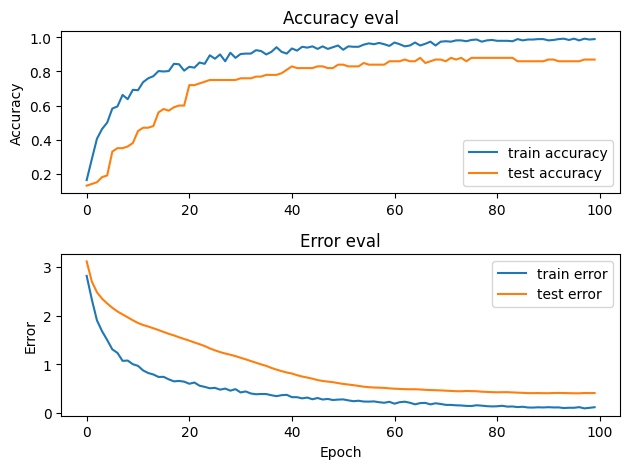

In [79]:
acc_err_plot(cnn_history_mfcc)

# LSTM

In [87]:
def _LSTM_model_compile(_X_train):
  _lstm = Sequential([
    LSTM(64, input_shape=(_X_train.shape[1], _X_train.shape[2]),
         return_sequences=True),
    LSTM(64),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    # output
    Dense(len(category_labelling_map), activation='softmax')
  ])
  
  _lstm.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return _lstm

def _LSTM_(_model, _X_train, _X_test, _y_train, _y_test, _epochs=100):
  _history = _model.fit(_X_train, _y_train,
                        validation_data=(_X_test, _y_test),
                        batch_size=64, epochs=_epochs)
  return _history

In [88]:
# Mel Spectogram
lstm_spect = _LSTM_model_compile(X_train_2_spect)
lstm_spect.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 15, 126, 32)       320       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 8, 63, 32)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_24 (Ba  (None, 8, 63, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_25 (Conv2D)          (None, 6, 61, 64)         18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 3, 31, 64)         0         
 ng2D)                                                           
                                                      

In [91]:
lstm_history_spect = _NN_(lstm_spect, X_train_2_spect, X_test_2_spect,
                          y_train_2_spect, y_test_2_spect)

Epoch 1/100
7/7 [==============================] - 1s 41ms/step - loss: 2.5887 - accuracy: 0.1275 - val_loss: 3.2330 - val_accuracy: 0.1100
Epoch 2/100
7/7 [==============================] - 0s 27ms/step - loss: 2.4165 - accuracy: 0.1750 - val_loss: 2.6609 - val_accuracy: 0.1300
Epoch 3/100
7/7 [==============================] - 0s 25ms/step - loss: 2.1733 - accuracy: 0.2550 - val_loss: 2.4413 - val_accuracy: 0.1300
Epoch 4/100
7/7 [==============================] - 0s 25ms/step - loss: 2.1637 - accuracy: 0.2375 - val_loss: 2.3275 - val_accuracy: 0.1600
Epoch 5/100
7/7 [==============================] - 0s 25ms/step - loss: 2.0366 - accuracy: 0.2975 - val_loss: 2.2543 - val_accuracy: 0.2000
Epoch 6/100
7/7 [==============================] - 0s 25ms/step - loss: 1.9387 - accuracy: 0.3150 - val_loss: 2.2013 - val_accuracy: 0.2100
Epoch 7/100
7/7 [==============================] - 0s 25ms/step - loss: 1.8743 - accuracy: 0.3475 - val_loss: 2.1652 - val_accuracy: 0.2000
Epoch 8/100
7/7 [===

In [93]:
_print_loss_accuracy(lstm_spect, X_test_2_spect, y_test_2_spect)

4/4 - 0s - loss: 1.5895 - accuracy: 0.4200 - 37ms/epoch - 9ms/step
Loss: 1.5894627571105957, Accuracy: 0.41999998688697815


In [96]:
# Mel Spectogram (Normalized)
lstm_spect_norm = _LSTM_model_compile(X_train_2_spect_norm)
lstm_spect_norm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 15, 126, 32)       320       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 8, 63, 32)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_30 (Ba  (None, 8, 63, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_31 (Conv2D)          (None, 6, 61, 64)         18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 3, 31, 64)         0         
 ng2D)                                                           
                                                     

In [97]:
lstm_history_spect_norm = _NN_(lstm_spect_norm, X_train_2_spect_norm, X_test_2_spect_norm,
                               y_train_2_spect_norm, y_test_2_spect_norm)

Epoch 1/100
7/7 [==============================] - 1s 37ms/step - loss: 3.0306 - accuracy: 0.1400 - val_loss: 2.4203 - val_accuracy: 0.0500
Epoch 2/100
7/7 [==============================] - 0s 25ms/step - loss: 2.6700 - accuracy: 0.1625 - val_loss: 2.3744 - val_accuracy: 0.0800
Epoch 3/100
7/7 [==============================] - 0s 25ms/step - loss: 2.3605 - accuracy: 0.1875 - val_loss: 2.3348 - val_accuracy: 0.0800
Epoch 4/100
7/7 [==============================] - 0s 25ms/step - loss: 2.2333 - accuracy: 0.2225 - val_loss: 2.3052 - val_accuracy: 0.1100
Epoch 5/100
7/7 [==============================] - 0s 25ms/step - loss: 2.1033 - accuracy: 0.2650 - val_loss: 2.2819 - val_accuracy: 0.1200
Epoch 6/100
7/7 [==============================] - 0s 26ms/step - loss: 2.0378 - accuracy: 0.2500 - val_loss: 2.2650 - val_accuracy: 0.1200
Epoch 7/100
7/7 [==============================] - 0s 25ms/step - loss: 1.9674 - accuracy: 0.2950 - val_loss: 2.2508 - val_accuracy: 0.1300
Epoch 8/100
7/7 [===

In [98]:
_print_loss_accuracy(lstm_spect_norm, X_test_2_spect_norm, y_test_2_spect_norm)

4/4 - 0s - loss: 1.3359 - accuracy: 0.5900 - 38ms/epoch - 9ms/step
Loss: 1.3359266519546509, Accuracy: 0.5899999737739563


In [99]:
# Mel Spectogram decibels (dB)
lstm_spect_db = _LSTM_model_compile(X_train_2_spect_db)
lstm_spect_db.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 15, 126, 32)       320       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 8, 63, 32)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_33 (Ba  (None, 8, 63, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_34 (Conv2D)          (None, 6, 61, 64)         18496     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 3, 31, 64)         0         
 ng2D)                                                           
                                                     

In [100]:
lstm_history_spect_db = _NN_(lstm_spect_db, X_train_2_spect_db, X_test_2_spect_db,
                             y_train_2_spect_db, y_test_2_spect_db)

Epoch 1/100
7/7 [==============================] - 1s 43ms/step - loss: 2.8368 - accuracy: 0.1050 - val_loss: 2.2605 - val_accuracy: 0.1500
Epoch 2/100
7/7 [==============================] - 0s 26ms/step - loss: 2.5398 - accuracy: 0.1300 - val_loss: 2.2291 - val_accuracy: 0.1600
Epoch 3/100
7/7 [==============================] - 0s 26ms/step - loss: 2.4055 - accuracy: 0.1625 - val_loss: 2.2087 - val_accuracy: 0.1800
Epoch 4/100
7/7 [==============================] - 0s 25ms/step - loss: 2.2290 - accuracy: 0.2000 - val_loss: 2.1931 - val_accuracy: 0.2100
Epoch 5/100
7/7 [==============================] - 0s 26ms/step - loss: 2.1308 - accuracy: 0.2300 - val_loss: 2.1828 - val_accuracy: 0.2200
Epoch 6/100
7/7 [==============================] - 0s 25ms/step - loss: 2.0278 - accuracy: 0.2725 - val_loss: 2.1737 - val_accuracy: 0.2700
Epoch 7/100
7/7 [==============================] - 0s 25ms/step - loss: 1.9698 - accuracy: 0.3050 - val_loss: 2.1668 - val_accuracy: 0.2300
Epoch 8/100
7/7 [===

In [101]:
_print_loss_accuracy(lstm_spect_db, X_test_2_spect_db, y_test_2_spect_db)

4/4 - 0s - loss: 1.5860 - accuracy: 0.5000 - 37ms/epoch - 9ms/step
Loss: 1.585968017578125, Accuracy: 0.5


In [111]:
# Mel-Frequency Cepstral Coefficients
lstm_mfcc = _LSTM_model_compile(X_train_2_mfcc)
lstm_mfcc.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 15, 18, 32)        320       
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 8, 9, 32)          0         
 ng2D)                                                           
                                                                 
 batch_normalization_48 (Ba  (None, 8, 9, 32)          128       
 tchNormalization)                                               
                                                                 
 conv2d_49 (Conv2D)          (None, 6, 7, 64)          18496     
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 3, 4, 64)          0         
 ng2D)                                                           
                                                     

In [112]:
lstm_history_mfcc = _NN_(lstm_mfcc, X_train_2_mfcc, X_test_2_mfcc, y_train_2_mfcc, y_test_2_mfcc)

Epoch 1/100
7/7 [==============================] - 1s 31ms/step - loss: 2.6441 - accuracy: 0.1200 - val_loss: 2.9769 - val_accuracy: 0.0500
Epoch 2/100
7/7 [==============================] - 0s 16ms/step - loss: 2.1807 - accuracy: 0.2625 - val_loss: 2.5683 - val_accuracy: 0.1500
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 1.8453 - accuracy: 0.4125 - val_loss: 2.3943 - val_accuracy: 0.1600
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 1.7139 - accuracy: 0.4725 - val_loss: 2.2846 - val_accuracy: 0.1700
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 1.5357 - accuracy: 0.5125 - val_loss: 2.1961 - val_accuracy: 0.1800
Epoch 6/100
7/7 [==============================] - 0s 15ms/step - loss: 1.4415 - accuracy: 0.5525 - val_loss: 2.1230 - val_accuracy: 0.1900
Epoch 7/100
7/7 [==============================] - 0s 16ms/step - loss: 1.3172 - accuracy: 0.5775 - val_loss: 2.0638 - val_accuracy: 0.3400
Epoch 8/100
7/7 [===

In [114]:
_print_loss_accuracy(lstm_mfcc, X_test_2_mfcc, y_test_2_mfcc)

4/4 - 0s - loss: 0.4045 - accuracy: 0.8300 - 27ms/epoch - 7ms/step
Loss: 0.40447208285331726, Accuracy: 0.8299999833106995


In [104]:
# Mel-Frequency Cepstral Coefficients (normalized)
lstm_mfcc_norm = _LSTM_model_compile(X_train_2_mfcc_norm)
lstm_mfcc_norm.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 15, 18, 32)        320       
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 8, 9, 32)          0         
 ng2D)                                                           
                                                                 
 batch_normalization_39 (Ba  (None, 8, 9, 32)          128       
 tchNormalization)                                               
                                                                 
 conv2d_40 (Conv2D)          (None, 6, 7, 64)          18496     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 3, 4, 64)          0         
 ng2D)                                                           
                                                     

In [105]:
lstm_history_mfcc_norm = _NN_(lstm_mfcc_norm, X_train_2_mfcc_norm, X_test_2_mfcc_norm,
                              y_train_2_mfcc_norm, y_test_2_mfcc_norm)

Epoch 1/100
7/7 [==============================] - 1s 29ms/step - loss: 2.7800 - accuracy: 0.1125 - val_loss: 2.3038 - val_accuracy: 0.0900
Epoch 2/100
7/7 [==============================] - 0s 16ms/step - loss: 2.6109 - accuracy: 0.1250 - val_loss: 2.3072 - val_accuracy: 0.0600
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 2.4858 - accuracy: 0.1550 - val_loss: 2.3115 - val_accuracy: 0.0600
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 2.2992 - accuracy: 0.2200 - val_loss: 2.3162 - val_accuracy: 0.0600
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 2.2119 - accuracy: 0.2075 - val_loss: 2.3207 - val_accuracy: 0.0600
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 2.1109 - accuracy: 0.2350 - val_loss: 2.3258 - val_accuracy: 0.0600
Epoch 7/100
7/7 [==============================] - 0s 16ms/step - loss: 1.9934 - accuracy: 0.2950 - val_loss: 2.3308 - val_accuracy: 0.0600
Epoch 8/100
7/7 [===

In [106]:
_print_loss_accuracy(lstm_mfcc_norm, X_test_2_mfcc_norm, y_test_2_mfcc_norm)

4/4 - 0s - loss: 1.3717 - accuracy: 0.5100 - 27ms/epoch - 7ms/step
Loss: 1.3717471361160278, Accuracy: 0.5099999904632568


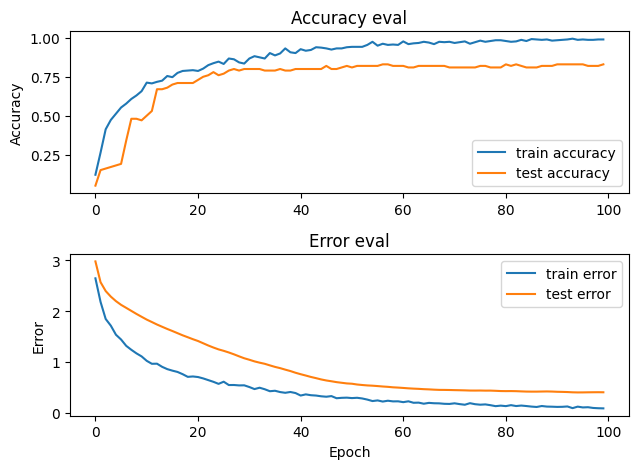

In [116]:
acc_err_plot(lstm_history_mfcc)

## Prediction by CNN (87%)

In [117]:
def prediction_by_model(model):
  rnd_test_index = random.randint(0, len(X_test_2_mfcc))

  x_to_predict = X_test_2_mfcc[rnd_test_index]
  y_to_predict = y_test_2_mfcc[rnd_test_index]
  
  # add 1 dimension to input data for sample - model.predict() expects a 4d array in this case
  x_to_predict = x_to_predict[np.newaxis, ...]
  
  prediction = model.predict(x_to_predict)
  
  predicted_index = np.argmax(prediction, axis=1)
  
  print(f"Target: {find_category(y_to_predict)}, Predicted label: {find_category(predicted_index)}; test index: {rnd_test_index}")

In [118]:
prediction_by_model(cnn_mfcc)

1/1 [==============================] - 0s 70ms/step
Target: Human, Predicted label: Human; test index: 95


In [119]:
prediction_by_model(cnn_mfcc)

1/1 [==============================] - 0s 16ms/step
Target: Police, Predicted label: Police; test index: 25


In [136]:
prediction_by_model(cnn_mfcc)

1/1 [==============================] - 0s 15ms/step
Target: Engine, Predicted label: Engine; test index: 85


# Performance metrics (Best from each algorithms)

In [141]:
def get_performance_metrics(_model, _X_test, _y_test, _prediction=None):
  if _prediction is None:
    _y_pred = _model.predict(_X_test)
    _prediction = np.argmax(_y_pred, axis=1)
  
  _accuracy = accuracy_score(_y_test, _prediction)
  _precision = precision_score(_y_test, _prediction, average='weighted')
  _recall = recall_score(_y_test, _prediction, average='weighted')
  _f1 = f1_score(_y_test, _prediction, average='weighted')
  _conf_matx = confusion_matrix(_y_test, _prediction)
  
  print(f"Accuracy: {_accuracy}")
  print(f"Precision: {_precision}")
  print(f"Recall: {_recall}")
  print(f"F1 Score: {_f1}")
  
  return _accuracy, _precision, _recall, _f1, _conf_matx

In [145]:
svm_accuracy, svm_precision, svm_recall, svm_f1, svm_conf_matx = get_performance_metrics(
  None, X_test_1_mfcc, y_test_1_mfcc, svm_predictions_mfcc 
)

Accuracy: 0.59
Precision: 0.619974358974359
Recall: 0.59
F1 Score: 0.5917658569500674


In [146]:
lr_accuracy, lr_precision, lr_recall, lr_f1, lr_conf_matx = get_performance_metrics(
  None, X_test_1_mfcc, y_test_1_mfcc, lr_predictions_mfcc 
)

Accuracy: 0.54
Precision: 0.5780194805194806
Recall: 0.54
F1 Score: 0.5493635477582846


In [147]:
dt_accuracy, dt_precision, dt_recall, dt_f1, dt_conf_matx = get_performance_metrics(
  None, X_test_1_spect, y_test_1_spect, dt_predictions_spect 
)

Accuracy: 0.57
Precision: 0.5796017316017317
Recall: 0.57
F1 Score: 0.5618878089873514


In [142]:
cnn_accuracy, cnn_precision, cnn_recall, cnn_f1, cnn_conf_matx = get_performance_metrics(
  cnn_mfcc, X_test_2_mfcc, y_test_2_mfcc
)

4/4 [==============================] - 0s 5ms/step
Accuracy: 0.87
Precision: 0.8746536796536796
Recall: 0.87
F1 Score: 0.8696137566137565


In [143]:
lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_conf_matx = get_performance_metrics(
  lstm_mfcc, X_test_2_mfcc, y_test_2_mfcc
)

4/4 [==============================] - 0s 6ms/step
Accuracy: 0.83
Precision: 0.8281060606060606
Recall: 0.83
F1 Score: 0.8244920634920635


## Performance metrics graph

In [148]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
performance_metrics = {
  'SVM': [svm_accuracy, svm_precision, svm_recall, svm_f1],
  'LR': [lr_accuracy, lr_precision, lr_recall, lr_f1],
  'DT': [dt_accuracy, dt_precision, dt_recall, dt_f1],
  'CNN': [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1],
  'LSTM': [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1],
}
performance_metrics

{'SVM': [0.59, 0.619974358974359, 0.59, 0.5917658569500674],
 'LR': [0.54, 0.5780194805194806, 0.54, 0.5493635477582846],
 'DT': [0.57, 0.5796017316017317, 0.57, 0.5618878089873514],
 'CNN': [0.87, 0.8746536796536796, 0.87, 0.8696137566137565],
 'LSTM': [0.83, 0.8281060606060606, 0.83, 0.8244920634920635]}

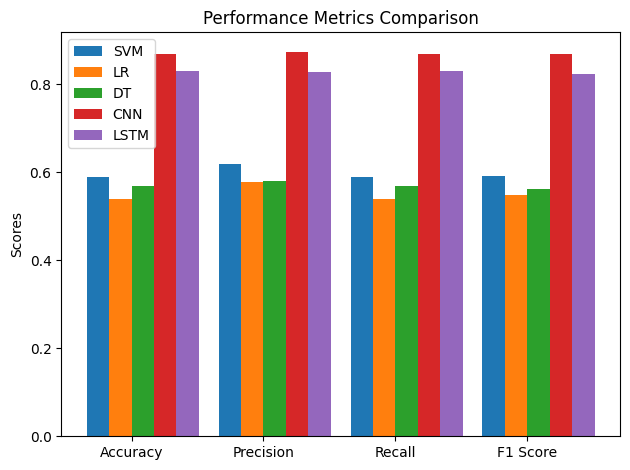

In [149]:
x = np.arange(4)  # total performance metrics
width = 0.17

fig, ax = plt.subplots()

for i, name in enumerate(["SVM", "LR", "DT", "CNN", "LSTM"]):
    ax.bar(x + width*i, performance_metrics[name], width, label=name)

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

# Confusion matrix

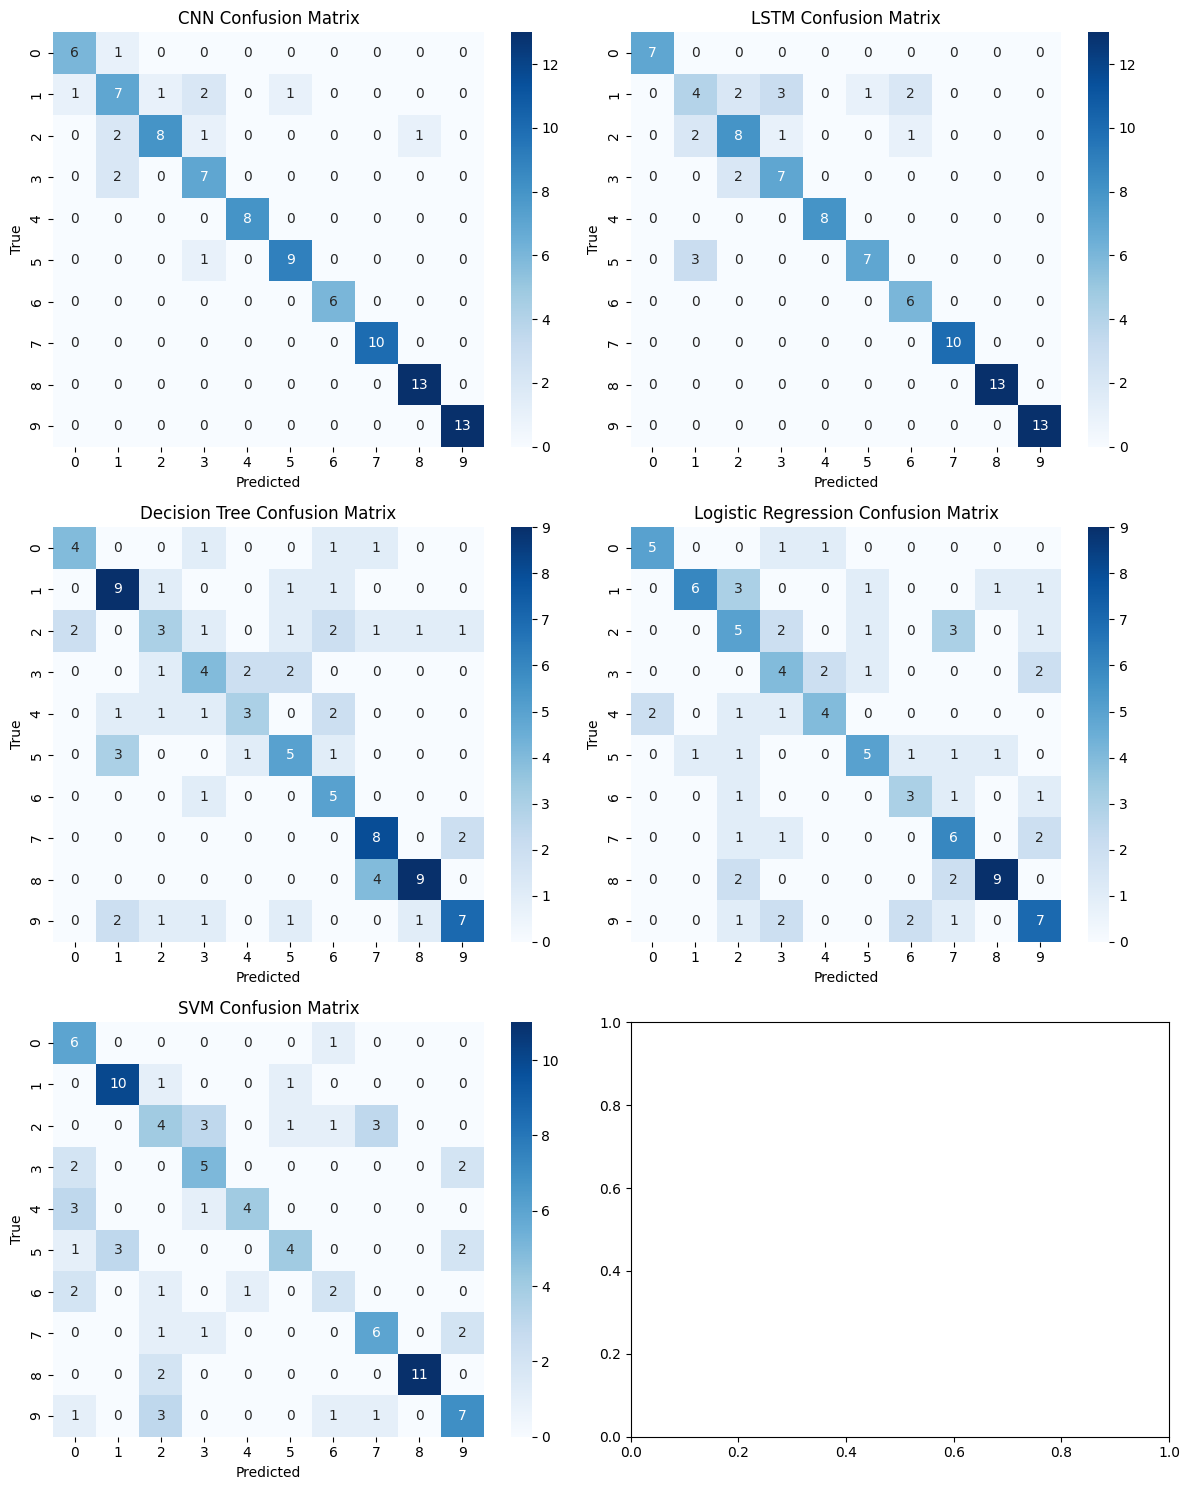

In [151]:
def plot_confusion_matrix(conf_mat, title, ax):
  sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=ax)
  ax.set_title(title + ' Confusion Matrix')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

plot_confusion_matrix(cnn_conf_matx, 'CNN', axes[0, 0])
plot_confusion_matrix(lstm_conf_matx, 'LSTM', axes[0, 1])
plot_confusion_matrix(dt_conf_matx, 'Decision Tree', axes[1, 0])
plot_confusion_matrix(lr_conf_matx, 'Logistic Regression', axes[1, 1])
plot_confusion_matrix(svm_conf_matx, 'SVM', axes[2, 0])

plt.tight_layout()
plt.show()
plt.close()

In [163]:
def calculate_metrics(conf_matrix):
  num_classes = len(conf_matrix)
  _metrics = {'TP': [0] * num_classes, 'TN': [0] * num_classes, 'FP': [0] * num_classes, 'FN': [0] * num_classes}
  
  for i in range(num_classes):
    _metrics['TP'][i] = conf_matrix[i, i]
    _metrics['TN'][i] = (np.sum(conf_matrix) - np.sum(conf_matrix[i, :])
                         - np.sum(conf_matrix[:, i]) + conf_matrix[i, i])
    _metrics['FP'][i] = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    _metrics['FN'][i] = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    
  for i2 in range(i+1):
      print(f"Class {i2+1}: TP={_metrics['TP'][i2]}, TN={_metrics['TN'][i2]}, FP={_metrics['FP'][i2]}, FN={_metrics['FN'][i2]}")

for alg in [svm_conf_matx, lr_conf_matx, dt_conf_matx, cnn_conf_matx, lstm_conf_matx]:
  calculate_metrics(alg)
  print("-"*20)

Class 1: TP=6, TN=84, FP=9, FN=1
Class 2: TP=10, TN=85, FP=3, FN=2
Class 3: TP=4, TN=80, FP=8, FN=8
Class 4: TP=5, TN=86, FP=5, FN=4
Class 5: TP=4, TN=91, FP=1, FN=4
Class 6: TP=4, TN=88, FP=2, FN=6
Class 7: TP=2, TN=91, FP=3, FN=4
Class 8: TP=6, TN=86, FP=4, FN=4
Class 9: TP=11, TN=87, FP=0, FN=2
Class 10: TP=7, TN=81, FP=6, FN=6
--------------------
Class 1: TP=5, TN=91, FP=2, FN=2
Class 2: TP=6, TN=87, FP=1, FN=6
Class 3: TP=5, TN=78, FP=10, FN=7
Class 4: TP=4, TN=84, FP=7, FN=5
Class 5: TP=4, TN=89, FP=3, FN=4
Class 6: TP=5, TN=87, FP=3, FN=5
Class 7: TP=3, TN=91, FP=3, FN=3
Class 8: TP=6, TN=82, FP=8, FN=4
Class 9: TP=9, TN=85, FP=2, FN=4
Class 10: TP=7, TN=80, FP=7, FN=6
--------------------
Class 1: TP=4, TN=91, FP=2, FN=3
Class 2: TP=9, TN=82, FP=6, FN=3
Class 3: TP=3, TN=84, FP=4, FN=9
Class 4: TP=4, TN=86, FP=5, FN=5
Class 5: TP=3, TN=89, FP=3, FN=5
Class 6: TP=5, TN=85, FP=5, FN=5
Class 7: TP=5, TN=87, FP=7, FN=1
Class 8: TP=8, TN=84, FP=6, FN=2
Class 9: TP=9, TN=85, FP=2, F